I used Google Colab Notebooks to calculate experiments. Here, for convinience, I mounted my Google drive where I stored the files.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
import copy 
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import warnings
warnings.filterwarnings('ignore')

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [4]:
data = pd.read_csv('/content/drive/My Drive/time series prediction/Metro_Interstate_Traffic_Volume.csv', parse_dates=True)

### Exploratory Data Analysis (EDA)

In [5]:
data.head()

holiday    temp  ...            date_time  traffic_volume
0    None  288.28  ...  2012-10-02 09:00:00            5545
1    None  289.36  ...  2012-10-02 10:00:00            4516
2    None  289.58  ...  2012-10-02 11:00:00            4767
3    None  290.13  ...  2012-10-02 12:00:00            5026
4    None  291.14  ...  2012-10-02 13:00:00            4918

[5 rows x 9 columns]

Here we can see several <br/>
**categorical** features: holiday, weather_main, weather_description.<br/>
**Continious** features: temp, rain_1h, show_1h, clouds_all.<br/>
**Target variable**: traffic_volume 

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


Checking for Nan values

In [7]:
for column in data.columns:
    print(column, sum(data[column].isna()))

holiday 0
temp 0
rain_1h 0
snow_1h 0
clouds_all 0
weather_main 0
weather_description 0
date_time 0
traffic_volume 0


Here I take into consideration two categorical variables, such as 'holiday' and 'weather_main' and then one-hot encode them.

In [8]:
data = pd.get_dummies(data, columns = ['holiday', 'weather_main'], drop_first=True)

In [9]:
data.head()

temp  rain_1h  ...  weather_main_Squall  weather_main_Thunderstorm
0  288.28      0.0  ...                    0                          0
1  289.36      0.0  ...                    0                          0
2  289.58      0.0  ...                    0                          0
3  290.13      0.0  ...                    0                          0
4  291.14      0.0  ...                    0                          0

[5 rows x 28 columns]

In [10]:
data.shape

(48204, 28)

Here we can see outliers in 'temp' variable, lets filter outliers with Interquartile range (IQR) method

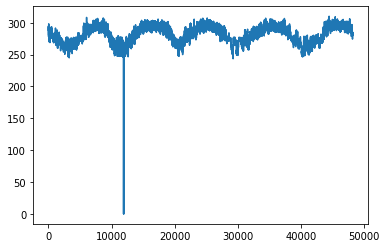

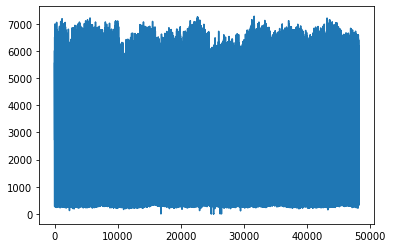

In [11]:
data['temp'].plot()
plt.show()
data['traffic_volume'].plot()
plt.show()

In [12]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

temp                                   19.646
rain_1h                                 0.000
snow_1h                                 0.000
clouds_all                             89.000
traffic_volume                       3740.000
holiday_Columbus Day                    0.000
holiday_Independence Day                0.000
holiday_Labor Day                       0.000
holiday_Martin Luther King Jr Day       0.000
holiday_Memorial Day                    0.000
holiday_New Years Day                   0.000
holiday_None                            0.000
holiday_State Fair                      0.000
holiday_Thanksgiving Day                0.000
holiday_Veterans Day                    0.000
holiday_Washingtons Birthday            0.000
weather_main_Clouds                     1.000
weather_main_Drizzle                    0.000
weather_main_Fog                        0.000
weather_main_Haze                       0.000
weather_main_Mist                       0.000
weather_main_Rain                 

In [13]:
data = data[~((data['temp'] < (Q1['temp'] - 1.5 * IQR['temp'])) |(data['temp'] > (Q3['temp'] + 1.5 * IQR['temp'])))]

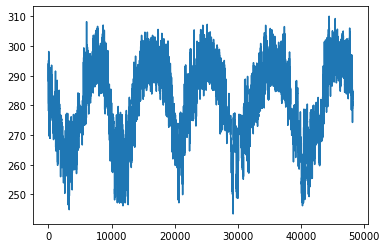

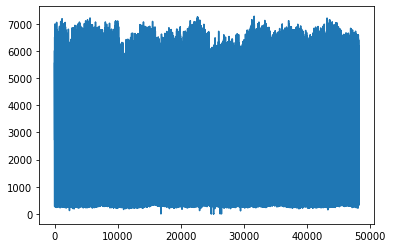

In [14]:
data['temp'].plot()
plt.show()
data['traffic_volume'].plot()
plt.show()

In [15]:
 data.drop(columns=['rain_1h', 'snow_1h', 'weather_description', 'date_time'], inplace=True)

#### Normalizing the features

In [16]:
features_to_norm = ['temp',	'clouds_all', 'traffic_volume']

In [17]:
TRAIN_SPLIT = 40000
STEP = 6

past_history = 720
future_target = 32
target_index = 2

tmp = data[features_to_norm].values
data_mean = tmp[:TRAIN_SPLIT].mean(axis=0)
data_std = tmp[:TRAIN_SPLIT].std(axis=0)

In [18]:
data[features_to_norm] = (data[features_to_norm]-data_mean)/data_std

In [19]:
data

temp  clouds_all  ...  weather_main_Squall  weather_main_Thunderstorm
0      0.581321   -0.261692  ...                    0                          0
1      0.668789    0.638749  ...                    0                          0
2      0.686606    1.024652  ...                    0                          0
3      0.731150    1.024652  ...                    0                          0
4      0.812948    0.638749  ...                    0                          0
...         ...         ...  ...                  ...                        ...
48199  0.190147    0.638749  ...                    0                          0
48200  0.134265    1.024652  ...                    0                          0
48201  0.131835    1.024652  ...                    0                          1
48202  0.080003    1.024652  ...                    0                          0
48203  0.082432    1.024652  ...                    0                          0

[48194 rows x 24 columns]

### Preparing training dataset/Visualizations
Here we will consider multiple future points prediction case given a past history.


In [20]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [21]:
trainX, trainY = multivariate_data(data.values, data.iloc[:, target_index].values, 0,
                                   TRAIN_SPLIT, past_history,
                                   future_target, STEP)

valX, valY = multivariate_data(data.values, data.iloc[:, target_index].values,
                               TRAIN_SPLIT, None, past_history,
                               future_target, STEP)

In [22]:
testX, testY = valX[:len(valX)//4], valY[:len(valY)//4]
valX, valY = valX[len(valX)//4:], valY[len(valY)//4:]

In [23]:
print('Train input features shape : {}'.format(trainX.shape))
print('\nTrain output shape : {}'.format(trainY.shape))
print('\nValidation input features shape : {}'.format(valX.shape))
print('\nValidation output shape : {}'.format(valY.shape))
print('\nTest input features shape : {}'.format(testX.shape))
print('\nTest output shape : {}'.format(testY.shape))

Train input features shape : (39280, 120, 24)

Train output shape : (39280, 32)

Validation input features shape : (5582, 120, 24)

Validation output shape : (5582, 32)

Test input features shape : (1860, 120, 24)

Test output shape : (1860, 32)


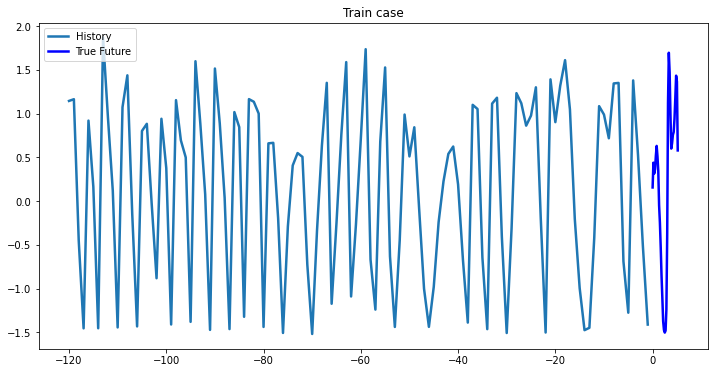

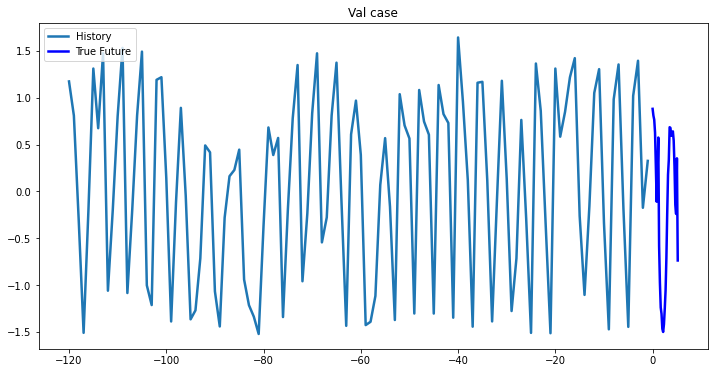

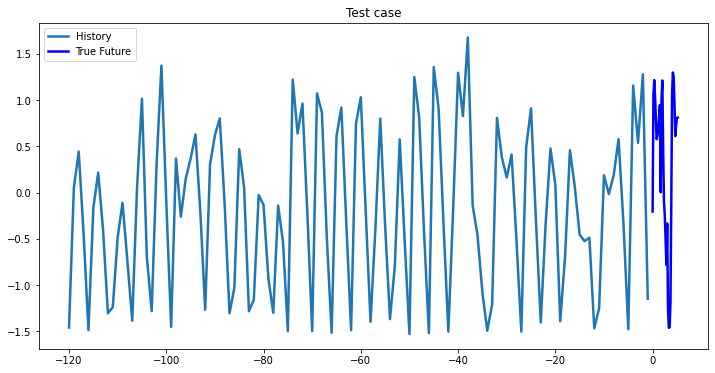

In [24]:
def create_time_steps(length):
    return list(range(-length, 0))

def multi_step_plot(history, true_future, prediction, pic_name):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history), label='History', linewidth=2.5)
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'b', label='True Future', linewidth=2.5)
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro', label='Predicted Future', linewidth=2.5)
    plt.legend(loc='upper left')
    plt.title(pic_name)
    plt.show()
    

multi_step_plot(trainX[0,:,target_index], trainY[0,:], np.array([0]), 'Train case')
multi_step_plot(valX[0,:,target_index], valY[0,:], np.array([0]), 'Val case')
multi_step_plot(testX[0,:,target_index], testY[0,:], np.array([0]), 'Test case')

### LSTM Time Series Predictor Model

For more efficient storing of long sequences, here I chose the LSTM architecture. LSTM layer consists from cells which is shown below. Two vectors are inputs to the LSTM-cell: the new input vector from the data $x_t$ and the vector of the hidden state $h_{t-1}$, which is obtained from the hidden state of this cell in the previous time step. The LSTM-cell consists of several number of gates and in addition to the hidden state vector, there is a "memory vector" or cell state $C_t$.<br/> 
Cell state on time step *t* is a linear combination of cell state on *t-1* time step $C_{t-1}$ with coefficients from *forget gate* and new *candidate cell state* $\tilde{C_t}$ with coefficients from *input gate*. When values of *forget gate* $f_t$ wiil be close to zero, cell state $C_{t-1}$ will be forgotten. Where values of *input gate* vector will be large, the new input vector will be added to that which already were in memory.

<a href="https://www.researchgate.net/figure/Structure-of-the-LSTM-cell-and-equations-that-describe-the-gates-of-an-LSTM-cell_fig5_329362532"><img src="https://www.researchgate.net/profile/Savvas_Varsamopoulos/publication/329362532/figure/fig5/AS:699592479870977@1543807253596/Structure-of-the-LSTM-cell-and-equations-that-describe-the-gates-of-an-LSTM-cell.jpg" alt="Structure of the LSTM cell and equations that describe the gates of an LSTM cell."/></a>

where,<br/>
$i_t$ - input gate; <br/>
$f_t$ - forget gate;<br/>
$o_t$ - output gate;<br/>
$\tilde{C_t}$ - new candidate cell state;<br/>
$C_t$ - cell state;<br/>
$h_t$ - block output.

Peepholes are often added to LSTM cells to increase model connectivity.

In [25]:
class LSTMTimeSeriesPredictor(nn.Module):

    def __init__(self, 
                 num_classes, 
                 n_features, 
                 hidden_size, 
                 num_layers, 
                 bidirectional=False,
                 dp_rate=0.5):
      
        super(LSTMTimeSeriesPredictor, self).__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        self.lstm = nn.LSTM(input_size=n_features, 
                            hidden_size=hidden_size,
                            num_layers=num_layers, 
                            dropout=dp_rate, 
                            batch_first=True, 
                            bidirectional=self.bidirectional)
        
        self.fc = nn.Linear(in_features=hidden_size, out_features=num_classes)

    def forward(self, x):
       # dim(x) = (batch, seq_len, input_size)
       # dim(h_0) = (num_layers * num_directions, batch, hidden_size)
        if self.bidirectional:
            h_0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size))
            c_0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size))
        else:
            h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
            c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))

        o, (h_out, _) = self.lstm(x, (h_0, c_0))

        if self.bidirectional:
            h_out = h_out.view(self.num_layers, 2, x.size(0), self.hidden_size)
            # taking last hidden state
            # dim(h_out) = (num_directions, batch, hidden_size)
            h_out = h_out[-1]

        # in bidectional case we sum vectors over num_directions
        # in the case of multi-layer LSTM we sum over num_layers direction
        # dim(h_out) = (batch, hidden_size)
        h_out = h_out.sum(dim=0)

        # dim(out) = (batch, num_classes)
        out = self.fc(h_out)
        return out        

In [26]:
trainX = torch.from_numpy(trainX).float()
trainY = torch.from_numpy(trainY).float()
valX = torch.from_numpy(valX).float()
valY = torch.from_numpy(valY).float()
testX = torch.from_numpy(testX).float()
testY = torch.from_numpy(testY).float()

In [27]:
train_data = torch.utils.data.TensorDataset(trainX, trainY)
val_data = torch.utils.data.TensorDataset(valX, valY)
test_data =  torch.utils.data.TensorDataset(testX, testY)

### Train and Evaluate Helping Functions

In [28]:
def train_model(model, train_data, loss_criterion, optimizer, batch_size):
      
    running_loss = 0.
    model.train()

    train_loader = torch.utils.data.DataLoader(train_data, 
                                              batch_size=batch_size, 
                                              shuffle=True, 
                                              num_workers=0)

    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()

        outputs = model(batch_x)

        loss = loss_criterion(outputs, batch_y)
    
        loss.backward()
    
        optimizer.step()
        
        running_loss += loss.item()
        
    epoch_loss = running_loss / (len(train_data) // batch_size)
    
    print("Epoch: %d, train loss: %1.5f" % (epoch+1, epoch_loss))

    return model, epoch_loss

In [29]:
def evaluate_model(model, val_data, loss_criterion, optimizer, batch_size):     
    running_loss = 0.
    model.eval()

    val_loader = torch.utils.data.DataLoader(val_data, 
                                             batch_size=batch_size, 
                                             shuffle=True, 
                                             num_workers=0)
    
    for batch_x, batch_y in val_loader:

        optimizer.zero_grad()

        with torch.set_grad_enabled(False):
            outputs = model(batch_x)
            loss = loss_criterion(outputs, batch_y)
                
        running_loss += loss.item()
    
    
    epoch_loss = running_loss / (len(val_data) // batch_size)
    
    print("Epoch: %d, val loss: %1.5f" % (epoch+1, epoch_loss))

    return model, epoch_loss, best_model_wts

### 1-Layer LSTM model

In [30]:
learning_rate = 0.001
input_size = trainX.shape[2] # number of input features, multivariate case
hidden_size = 20
num_layers = 1
num_classes = trainY.shape[1] # future time window length
lstm_model = LSTMTimeSeriesPredictor(num_classes, input_size, hidden_size, num_layers, bidirectional=False)

config = {'batch_size': 128, 'num_epochs': 10, 'checkpoints_dir': '/content/drive/My Drive/time series prediction/', 'model_filename': '1-layer-lstm-best_model.pth.tar'}

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm_model.parameters(), lr=learning_rate)

train_history, val_history = [], []

best_model_wts = copy.deepcopy(lstm_model.state_dict())
       
best_loss = 10e10  # for validation phase

if not os.path.exists(config['checkpoints_dir']):
    os.mkdir(config['checkpoints_dir'])

for epoch in range(config['num_epochs']):
    print("="*20 + str(epoch+1) + "="*20)
    _, train_loss = train_model(lstm_model, train_data, criterion, optimizer, config['batch_size'])
    train_history.append(train_loss)

    _, val_loss, best_model_wts = evaluate_model(lstm_model, val_data, criterion, optimizer, config['batch_size'])
    val_history.append(val_loss)

    if val_loss < best_loss:
        best_loss = val_loss
        print("Saving model for best loss")
        checkpoint = {
            'state_dict': best_model_wts
        }
        torch.save(checkpoint, config['checkpoints_dir'] + config['model_filename'])
        best_model_wts = copy.deepcopy(lstm_model.state_dict())

====================1====================
Epoch: 1, train loss: 0.90311
Epoch: 1, val loss: 0.78379
Saving model for best loss
====================2====================
Epoch: 2, train loss: 0.77797
Epoch: 2, val loss: 0.73462
Saving model for best loss
====================3====================
Epoch: 3, train loss: 0.74900
Epoch: 3, val loss: 0.70943
Saving model for best loss
====================4====================
Epoch: 4, train loss: 0.73103
Epoch: 4, val loss: 0.69784
Saving model for best loss
====================5====================
Epoch: 5, train loss: 0.71739
Epoch: 5, val loss: 0.68612
Saving model for best loss
====================6====================
Epoch: 6, train loss: 0.70665
Epoch: 6, val loss: 0.67945
Saving model for best loss
====================7====================
Epoch: 7, train loss: 0.69868
Epoch: 7, val loss: 0.67938
Saving model for best loss
====================8====================
Epoch: 8, train loss: 0.69284
Epoch: 8, val loss: 0.67938
===========

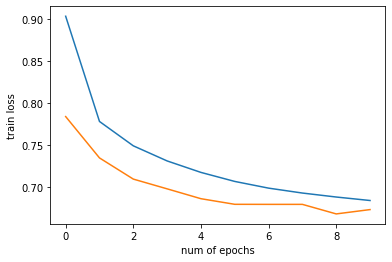

In [31]:
plt.plot(np.arange(config['num_epochs']), train_history, label='Train loss')
plt.plot(np.arange(config['num_epochs']), val_history, label='Val loss')
plt.xlabel("num of epochs")
plt.ylabel("train loss")
plt.show()

#### Test

In [32]:
lstm_model = LSTMTimeSeriesPredictor(num_classes, input_size, hidden_size, num_layers)
lstm_model.load_state_dict(torch.load(os.path.join(config['checkpoints_dir'], config['model_filename']))['state_dict'])
lstm_model.eval()
for param in lstm_model.parameters():
    param.requires_grad = False

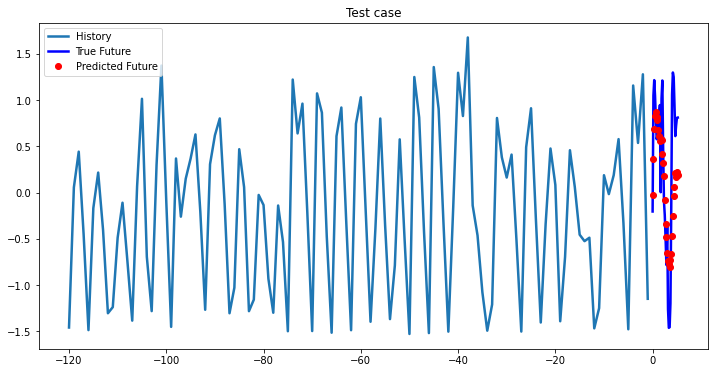

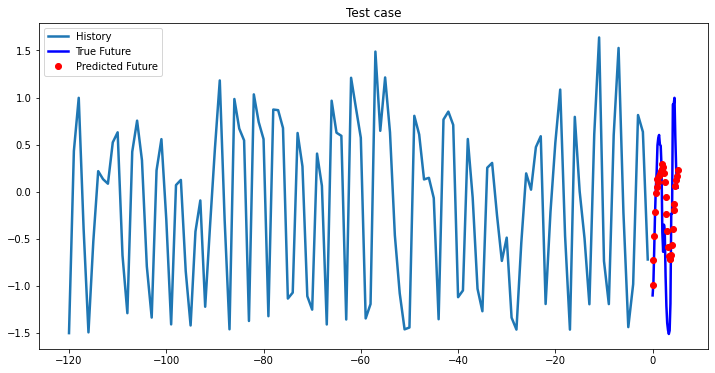

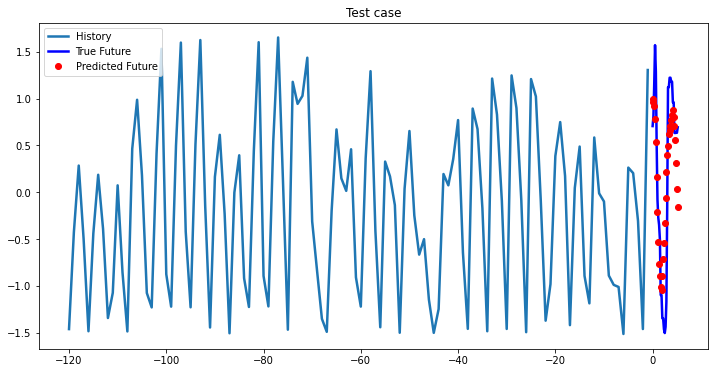

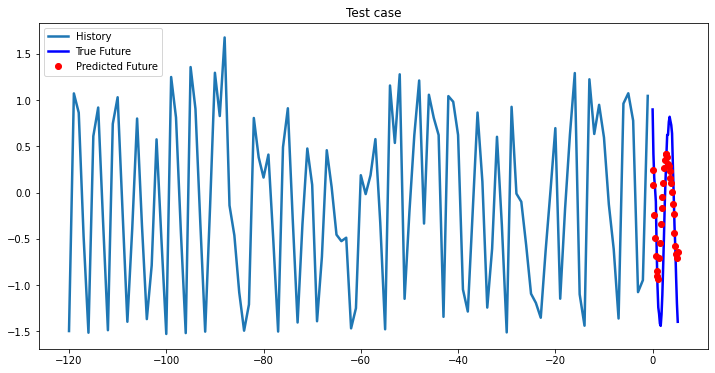

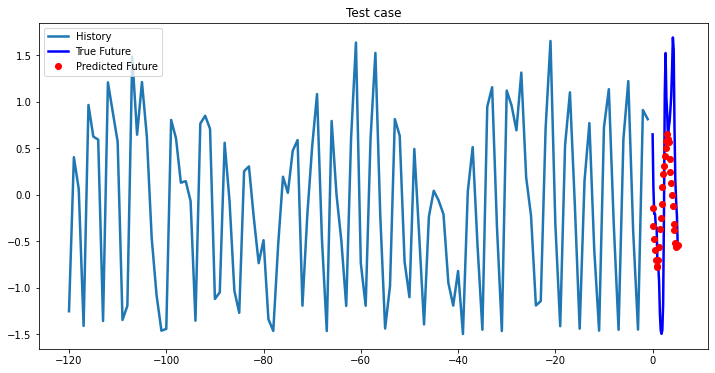

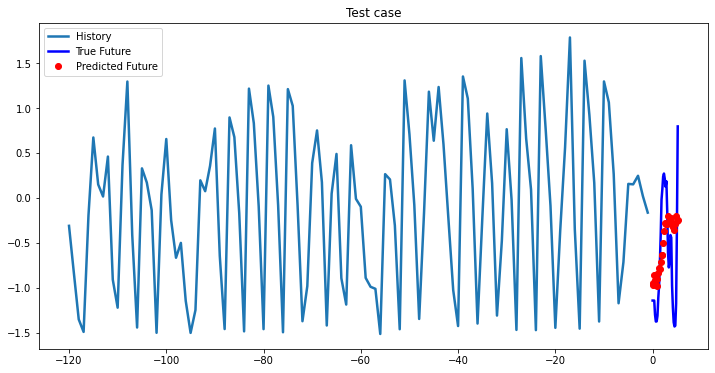

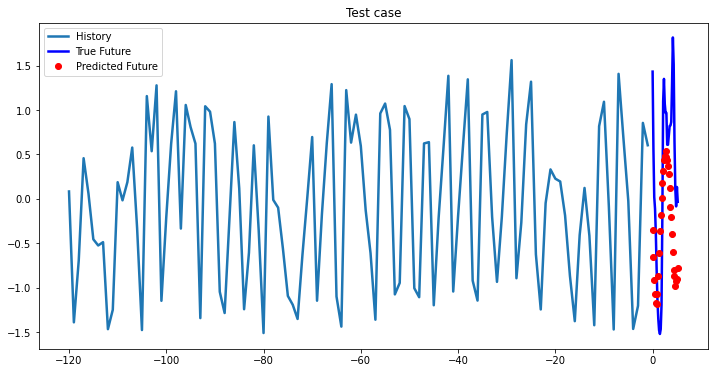

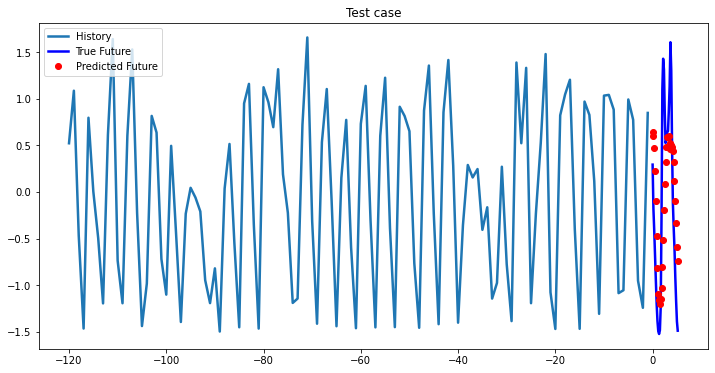

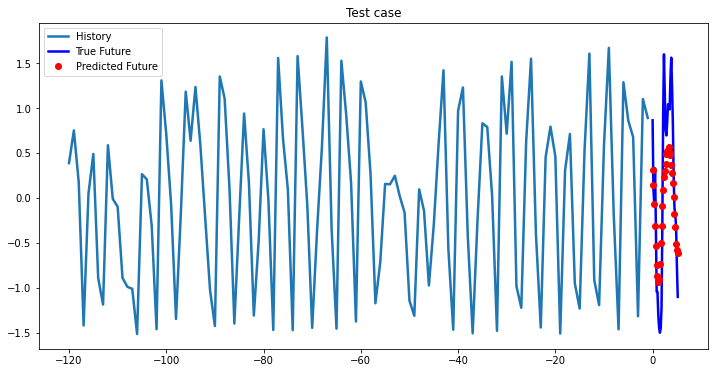

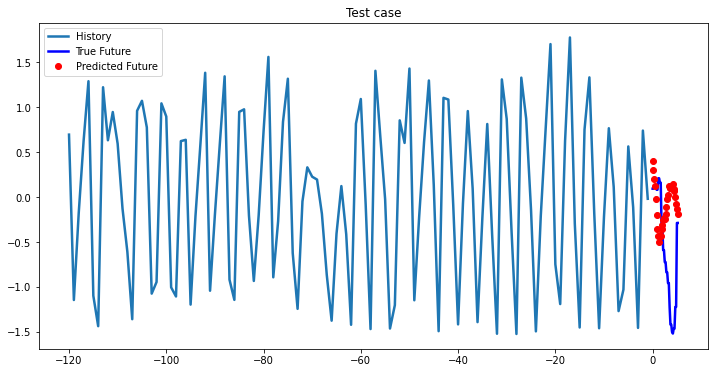

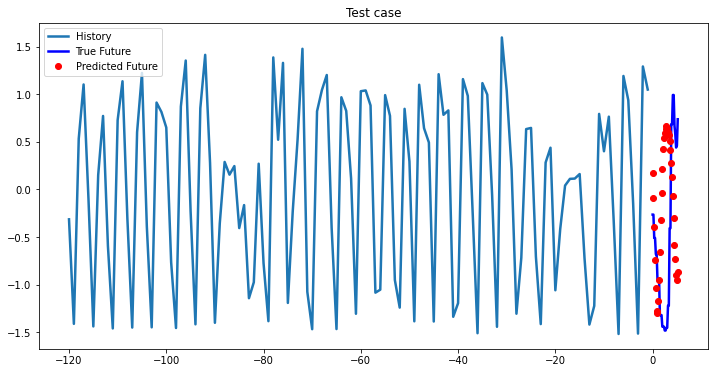

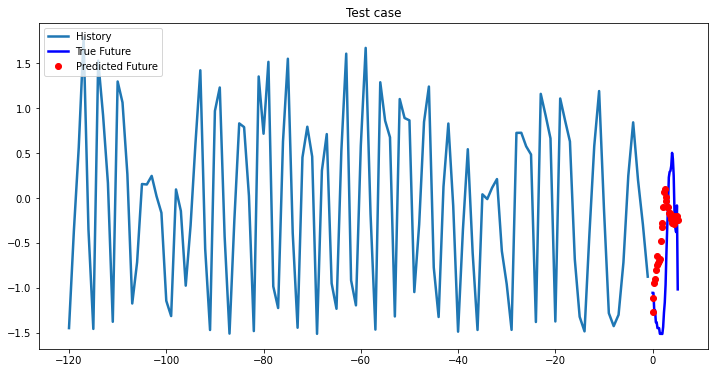

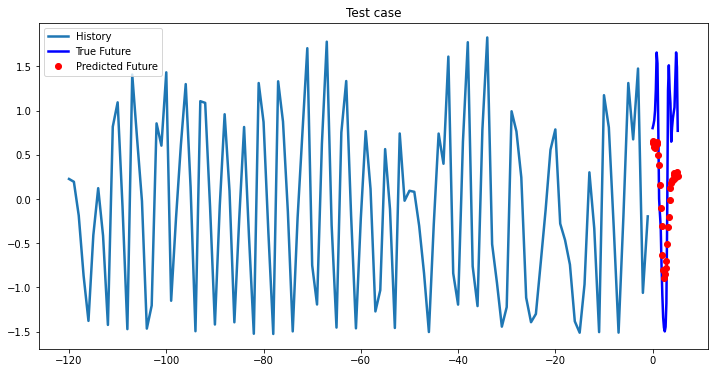

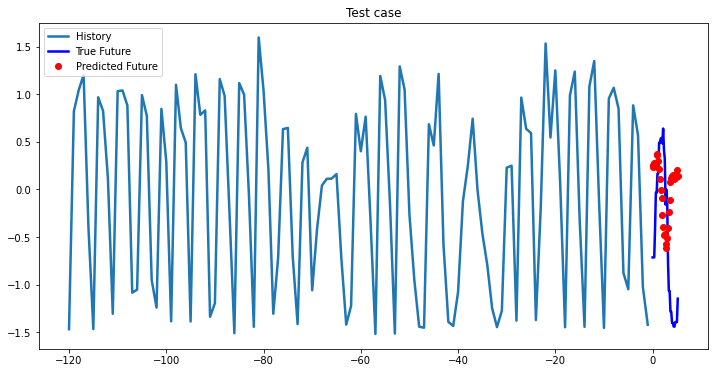

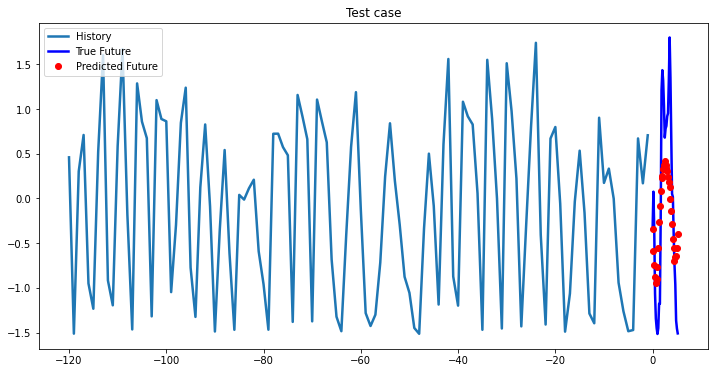

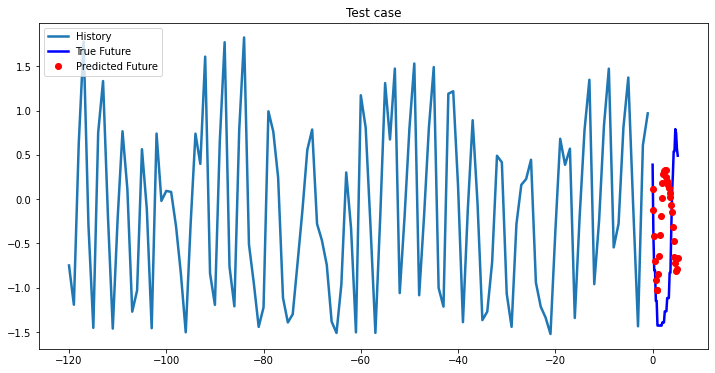

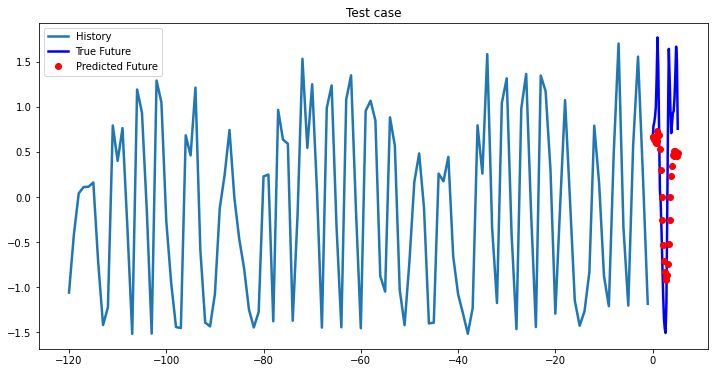

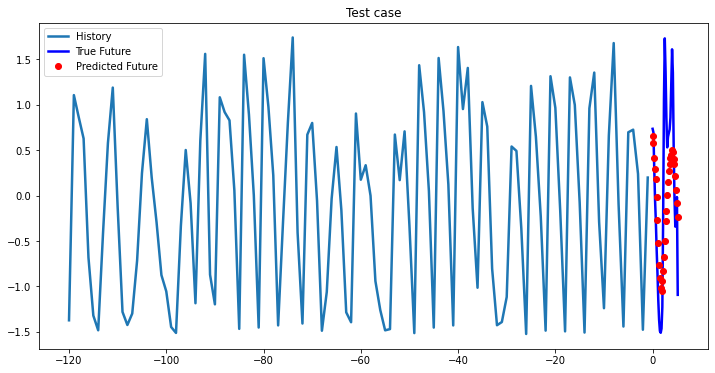

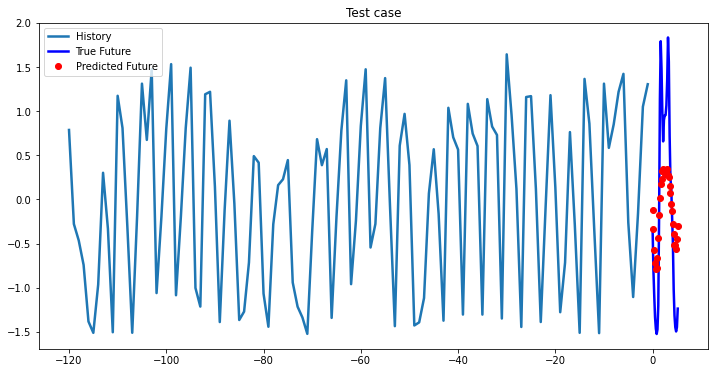

In [33]:
i = 0
while i < len(testX):
    test_x = testX[i].unsqueeze(0)
    test_y = testY[i].unsqueeze(0)
    multi_step_plot(test_x.numpy()[0, :, target_index], test_y.detach().numpy()[0, :], lstm_model(test_x).detach().numpy()[0, :], 'Test case')
    i += 100

### 2-Layer LSTM

In [34]:
learning_rate = 0.001
input_size = trainX.shape[2] # number of input features, multivariate case
hidden_size = 20
num_layers = 2
num_classes = trainY.shape[1] # future time window length
lstm_model = LSTMTimeSeriesPredictor(num_classes, input_size, hidden_size, num_layers, bidirectional=False)

config = {'batch_size': 128, 'num_epochs': 10, 'checkpoints_dir': '/content/drive/My Drive/time series prediction/', 'model_filename': '2-layer-lstm-best_model.pth.tar'}

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm_model.parameters(), lr=learning_rate)

train_history, val_history = [], []

best_model_wts = copy.deepcopy(lstm_model.state_dict())
       
best_loss = 10e10

if not os.path.exists(config['checkpoints_dir']):
    os.mkdir(config['checkpoints_dir'])

for epoch in range(config['num_epochs']):
    print("="*20 + str(epoch+1) + "="*20)
    _, train_loss = train_model(lstm_model, train_data, criterion, optimizer, config['batch_size'])
    train_history.append(train_loss)

    _, val_loss, best_model_wts = evaluate_model(lstm_model, val_data, criterion, optimizer, config['batch_size'])
    val_history.append(val_loss)

    if val_loss < best_loss:
        best_loss = val_loss
        print("Saving model for best loss")
        checkpoint = {
            'state_dict': best_model_wts
        }
        torch.save(checkpoint, config['checkpoints_dir'] + config['model_filename'])
        best_model_wts = copy.deepcopy(lstm_model.state_dict())

====================1====================
Epoch: 1, train loss: 0.89874
Epoch: 1, val loss: 0.77490
Saving model for best loss
====================2====================
Epoch: 2, train loss: 0.77985
Epoch: 2, val loss: 0.73741
Saving model for best loss
====================3====================
Epoch: 3, train loss: 0.75368
Epoch: 3, val loss: 0.71219
Saving model for best loss
====================4====================
Epoch: 4, train loss: 0.73283
Epoch: 4, val loss: 0.69299
Saving model for best loss
====================5====================
Epoch: 5, train loss: 0.71830
Epoch: 5, val loss: 0.68409
Saving model for best loss
====================6====================
Epoch: 6, train loss: 0.70771
Epoch: 6, val loss: 0.67732
Saving model for best loss
====================7====================
Epoch: 7, train loss: 0.69788
Epoch: 7, val loss: 0.67322
Saving model for best loss
====================8====================
Epoch: 8, train loss: 0.69050
Epoch: 8, val loss: 0.67194
Saving mode

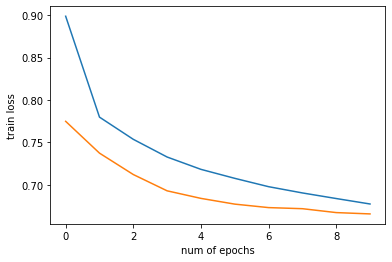

In [35]:
plt.plot(np.arange(config['num_epochs']), train_history, label='Train loss')
plt.plot(np.arange(config['num_epochs']), val_history, label='Val loss')
plt.xlabel("num of epochs")
plt.ylabel("train loss")
plt.show()

#### Test

In [36]:
lstm_model = LSTMTimeSeriesPredictor(num_classes, input_size, hidden_size, num_layers)
lstm_model.load_state_dict(torch.load(os.path.join(config['checkpoints_dir'], config['model_filename']))['state_dict'])
lstm_model.eval()
for param in lstm_model.parameters():
    param.requires_grad = False

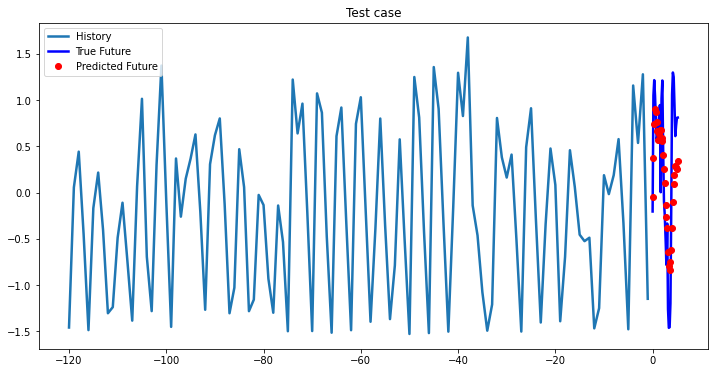

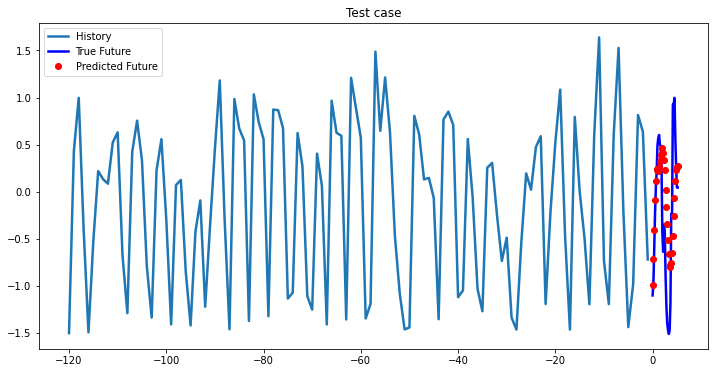

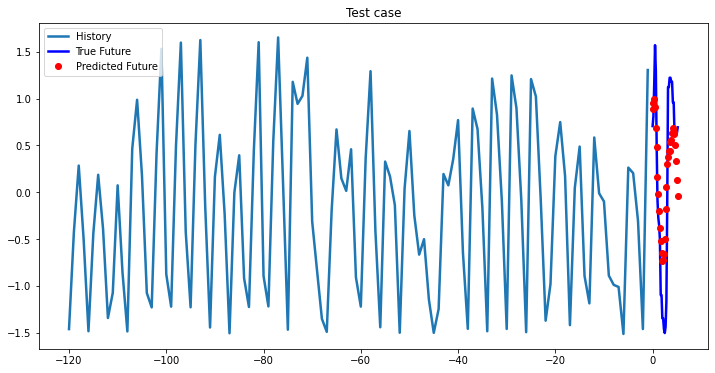

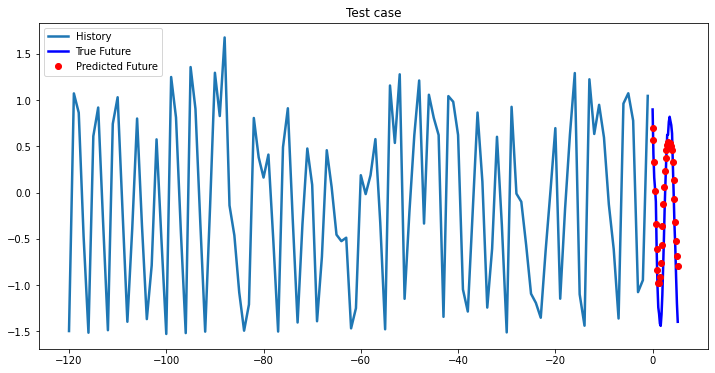

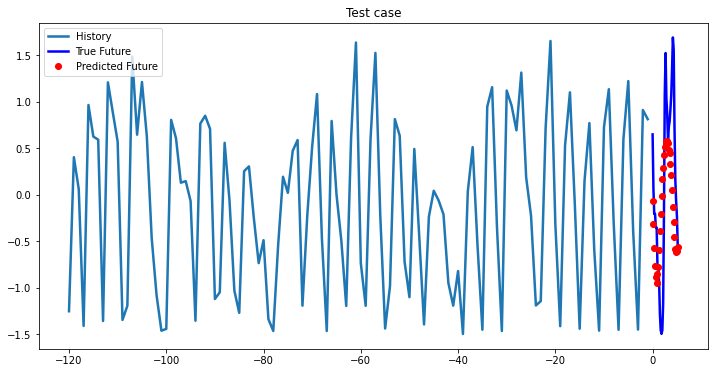

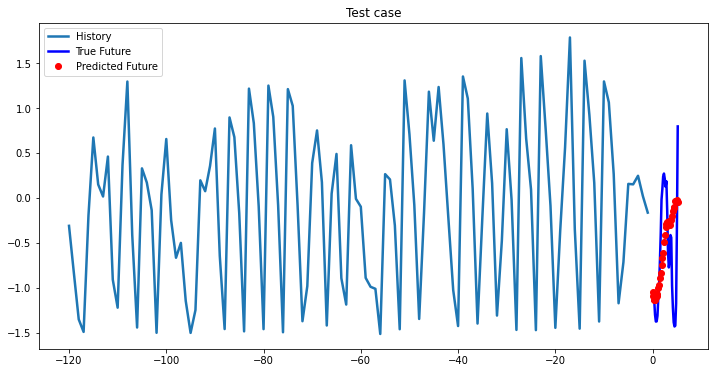

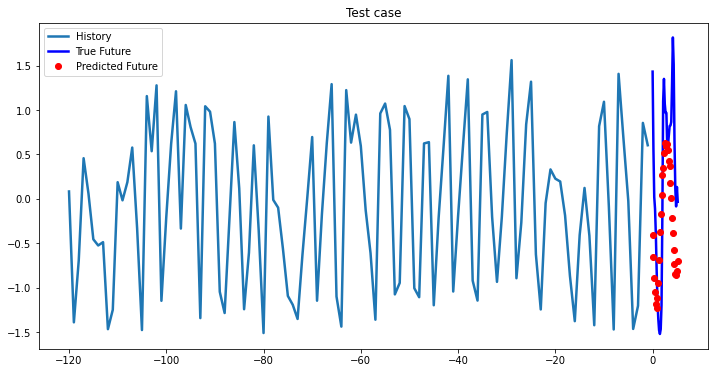

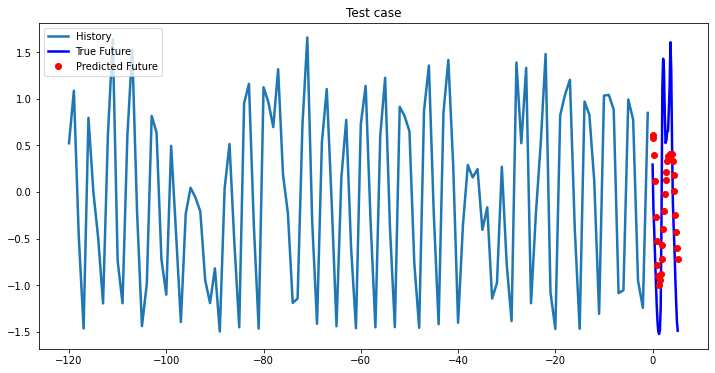

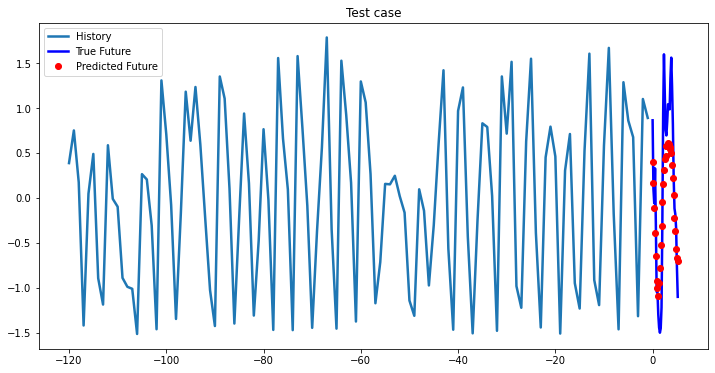

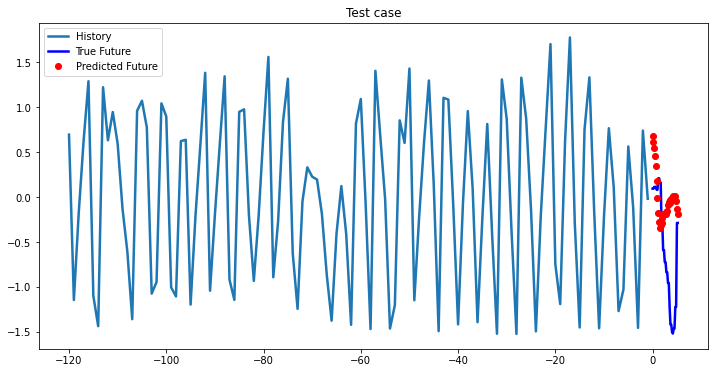

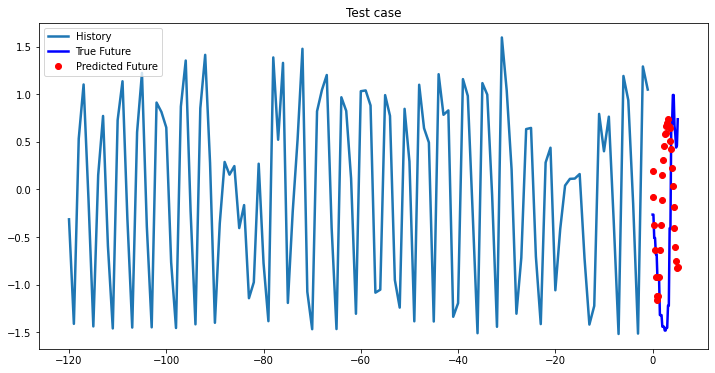

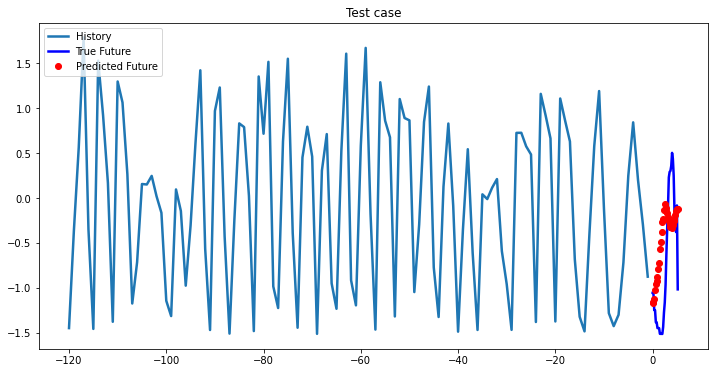

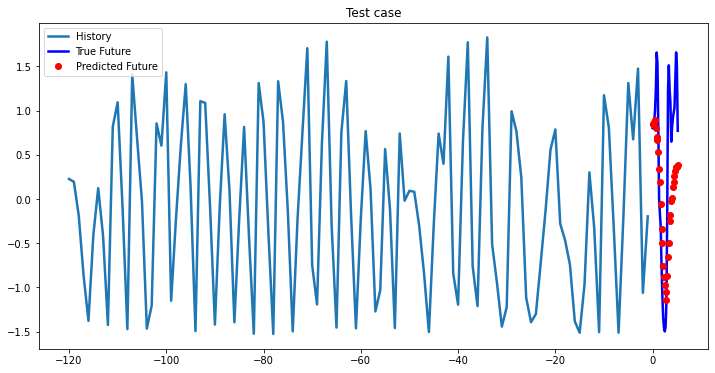

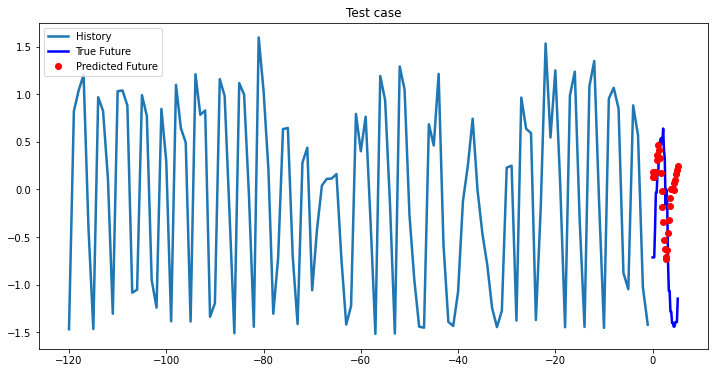

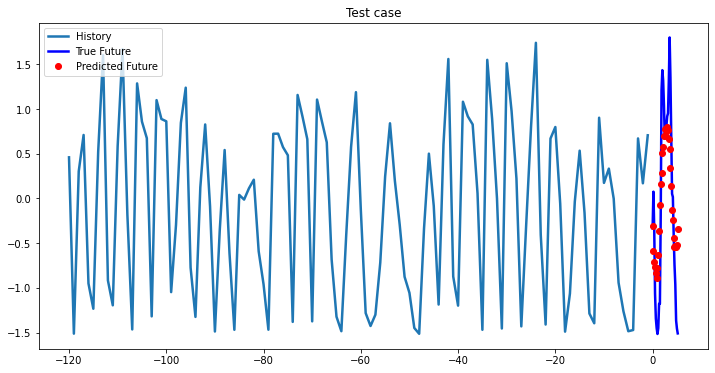

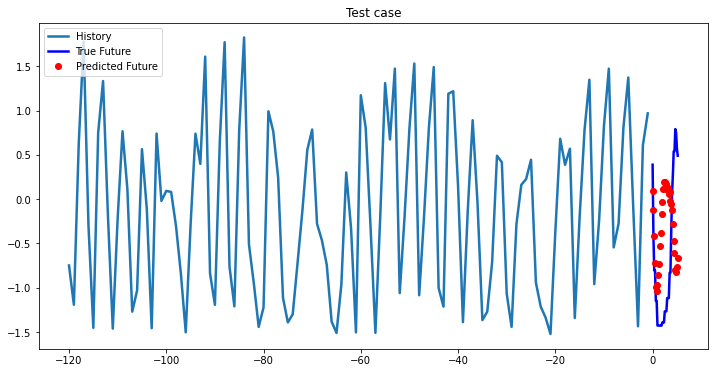

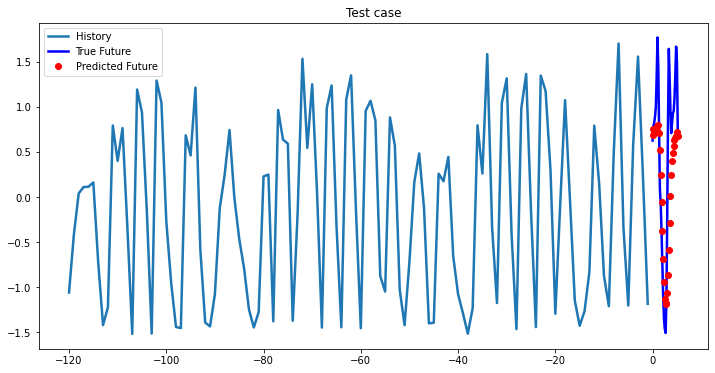

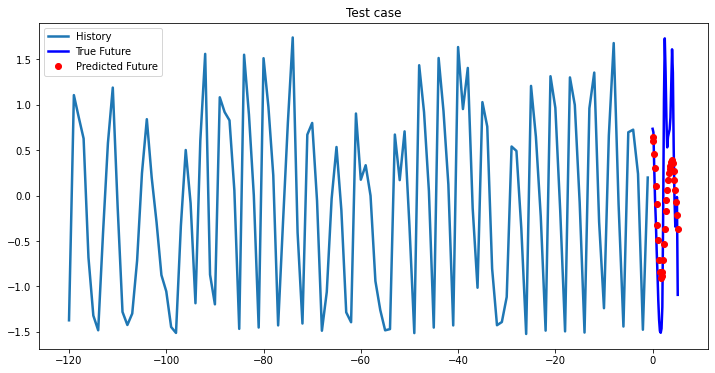

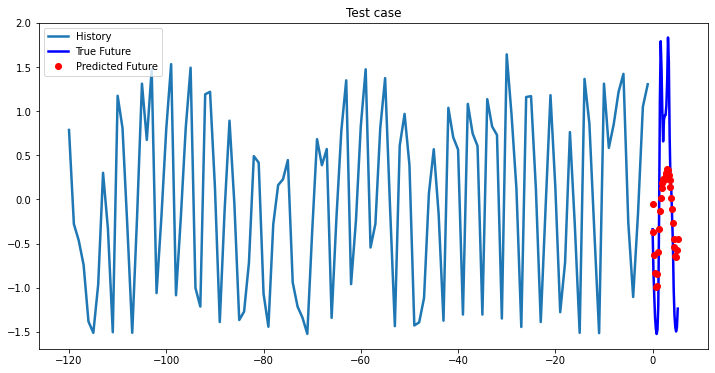

In [37]:
i = 0
while i < len(testX):
    test_x = testX[i].unsqueeze(0)
    test_y = testY[i].unsqueeze(0)
    multi_step_plot(test_x.numpy()[0, :, target_index], test_y.detach().numpy()[0, :], lstm_model(test_x).detach().numpy()[0, :], 'Test case')
    i += 100

### Bidirectional 1-Layer LSTM

In [38]:
learning_rate = 0.001
input_size = trainX.shape[2] # number of input features, multivariate case
hidden_size = 20
num_layers = 1
num_classes = trainY.shape[1] # future time window length
lstm_model = LSTMTimeSeriesPredictor(num_classes, input_size, hidden_size, num_layers, bidirectional=True)

config = {'batch_size': 128, 'num_epochs': 10, 'checkpoints_dir': '/content/drive/My Drive/time series prediction/', 'model_filename': 'bidir-1-layer-lstm-best_model.pth.tar'}

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm_model.parameters(), lr=learning_rate)

train_history, val_history = [], []

best_model_wts = copy.deepcopy(lstm_model.state_dict())
       
best_loss = 10e10  # for validation phase

if not os.path.exists(config['checkpoints_dir']):
    os.mkdir(config['checkpoints_dir'])

for epoch in range(config['num_epochs']):
    print("="*20 + str(epoch+1) + "="*20)
    _, train_loss = train_model(lstm_model, train_data, criterion, optimizer, config['batch_size'])
    train_history.append(train_loss)

    _, val_loss, best_model_wts = evaluate_model(lstm_model, val_data, criterion, optimizer, config['batch_size'])
    val_history.append(val_loss)

    if val_loss < best_loss:
        best_loss = val_loss
        print("Saving model for best loss")
        checkpoint = {
            'state_dict': best_model_wts
        }
        torch.save(checkpoint, config['checkpoints_dir'] + config['model_filename'])
        best_model_wts = copy.deepcopy(lstm_model.state_dict())

====================1====================
Epoch: 1, train loss: 0.92054
Epoch: 1, val loss: 0.78858
Saving model for best loss
====================2====================
Epoch: 2, train loss: 0.77843
Epoch: 2, val loss: 0.73070
Saving model for best loss
====================3====================
Epoch: 3, train loss: 0.75058
Epoch: 3, val loss: 0.71063
Saving model for best loss
====================4====================
Epoch: 4, train loss: 0.73297
Epoch: 4, val loss: 0.69804
Saving model for best loss
====================5====================
Epoch: 5, train loss: 0.71834
Epoch: 5, val loss: 0.68801
Saving model for best loss
====================6====================
Epoch: 6, train loss: 0.70628
Epoch: 6, val loss: 0.67993
Saving model for best loss
====================7====================
Epoch: 7, train loss: 0.69642
Epoch: 7, val loss: 0.67463
Saving model for best loss
====================8====================
Epoch: 8, train loss: 0.68780
Epoch: 8, val loss: 0.67683
===========

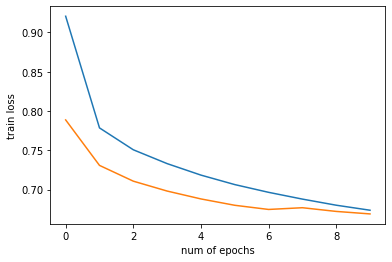

In [39]:
plt.plot(np.arange(config['num_epochs']), train_history, label='Train loss')
plt.plot(np.arange(config['num_epochs']), val_history, label='Val loss')
plt.xlabel("num of epochs")
plt.ylabel("train loss")
plt.show()

#### Test

In [40]:
from collections import OrderedDict

state_dict = torch.load(os.path.join(config['checkpoints_dir'], config['model_filename']))['state_dict']

new_state_dict = OrderedDict()
for k,v in state_dict.items():
    if k not in ["lstm.weight_ih_l0_reverse", "lstm.weight_hh_l0_reverse", "lstm.bias_ih_l0_reverse", "lstm.bias_hh_l0_reverse"]:
        new_state_dict[k] = v

In [41]:
lstm_model = LSTMTimeSeriesPredictor(num_classes, input_size, hidden_size, num_layers)
lstm_model.load_state_dict(new_state_dict)
lstm_model.eval()
for param in lstm_model.parameters():
    param.requires_grad = False

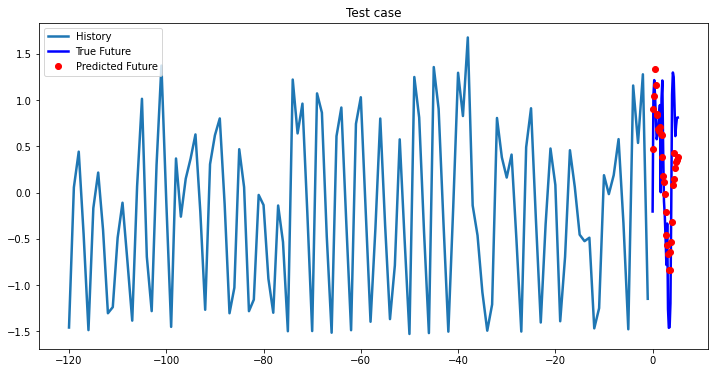

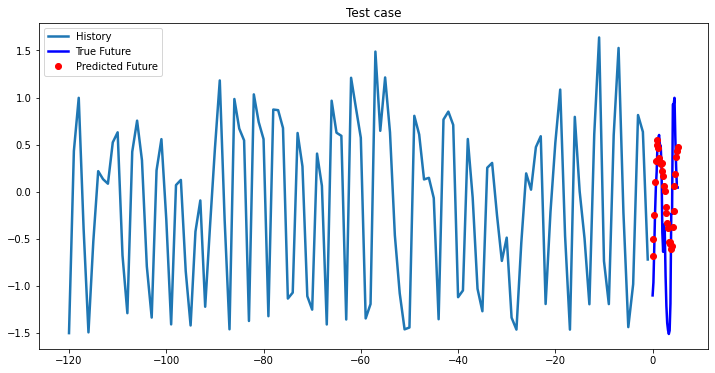

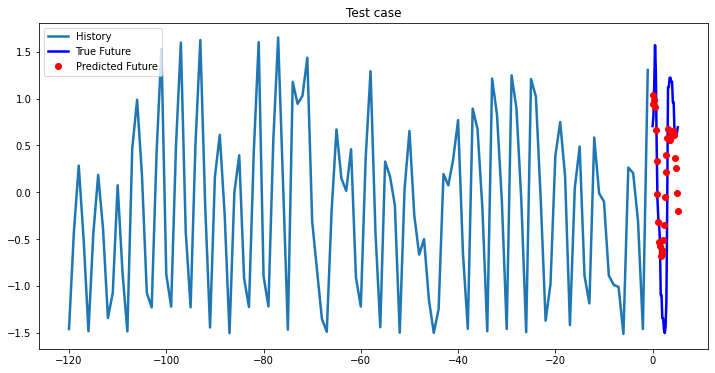

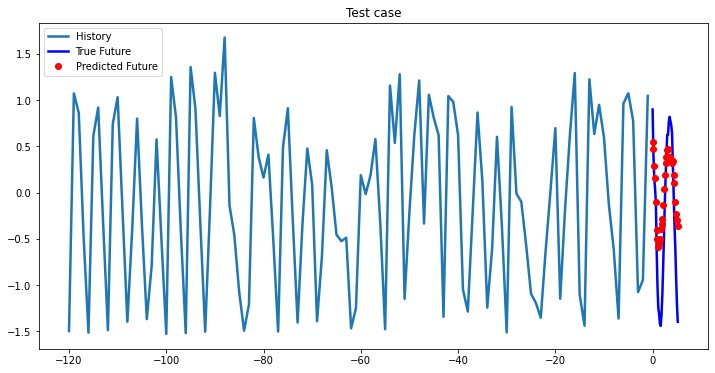

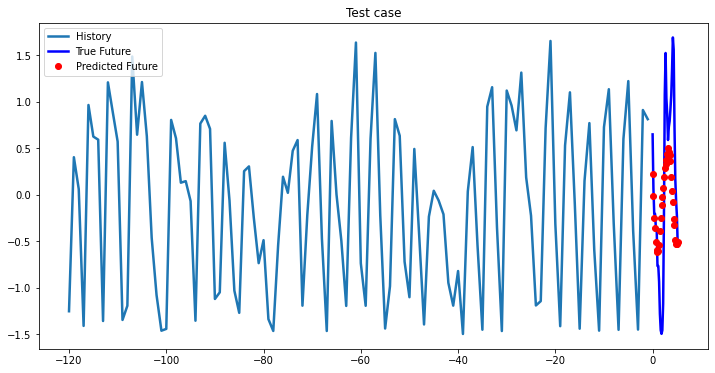

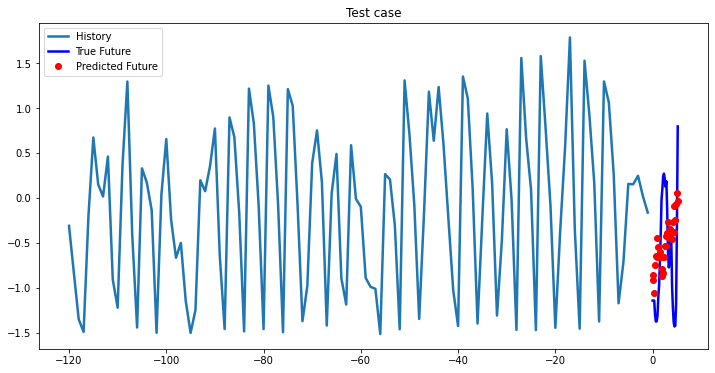

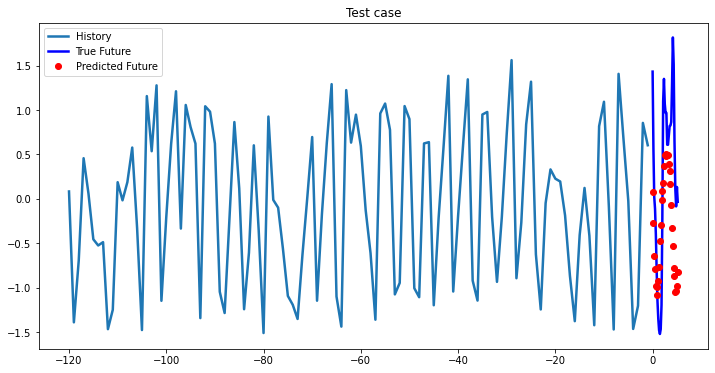

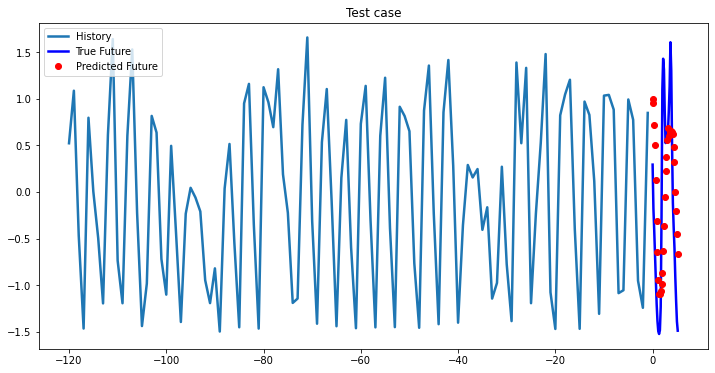

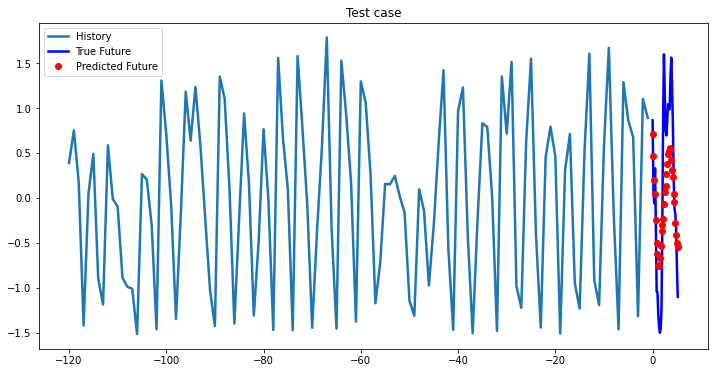

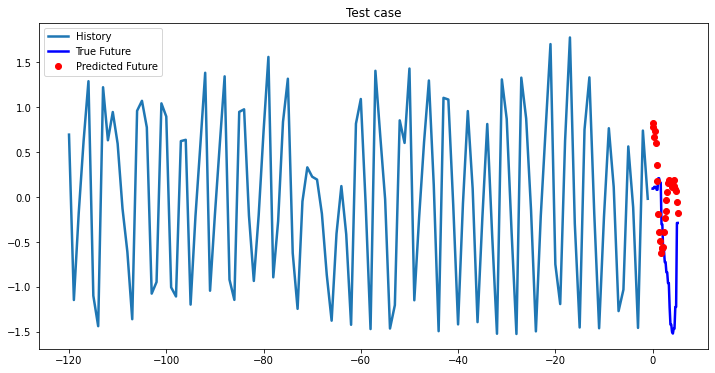

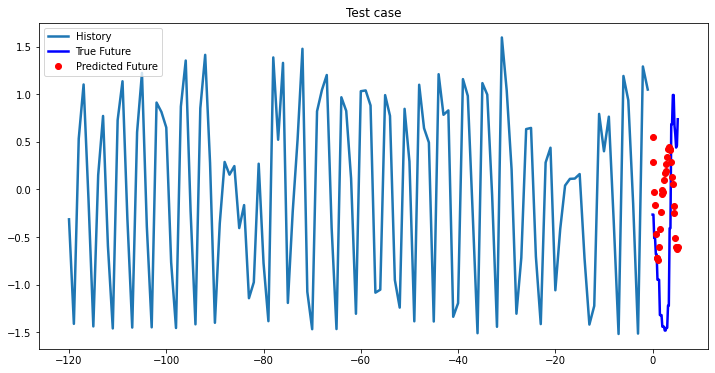

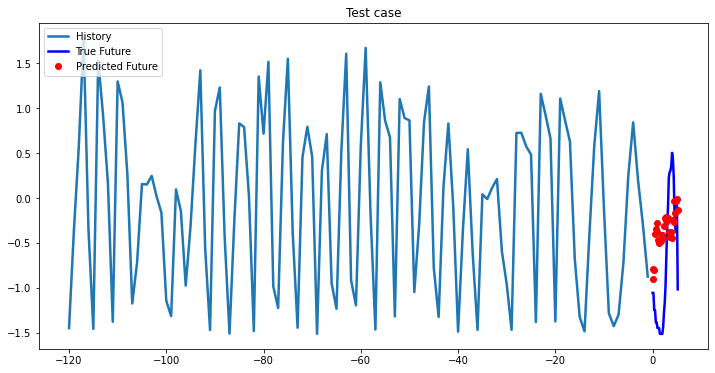

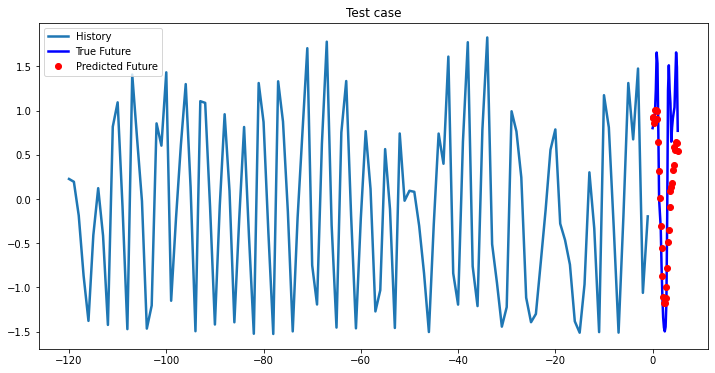

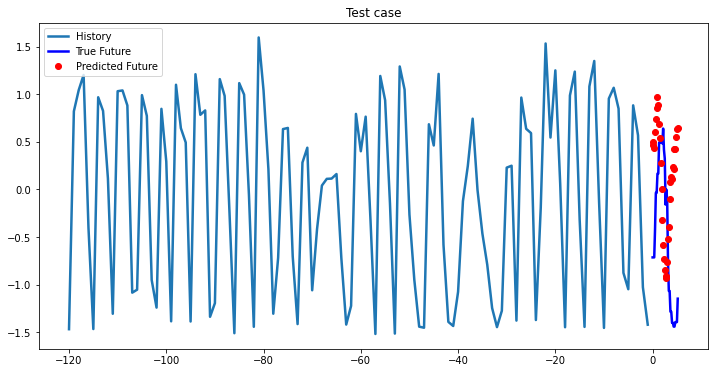

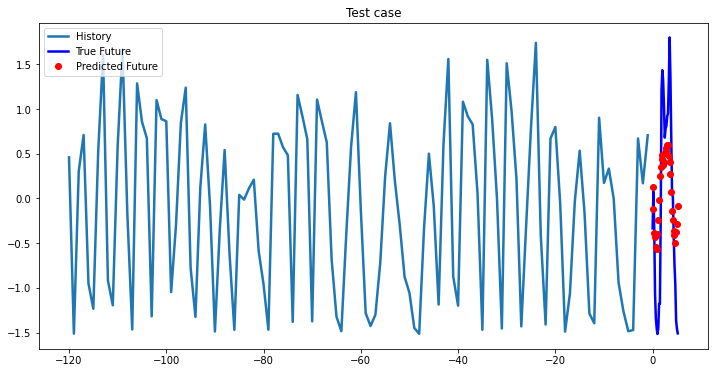

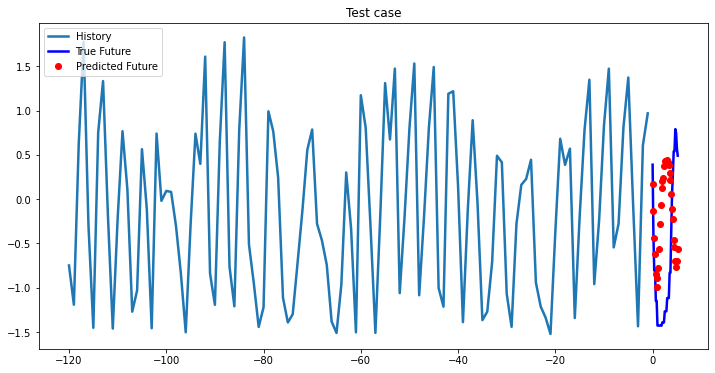

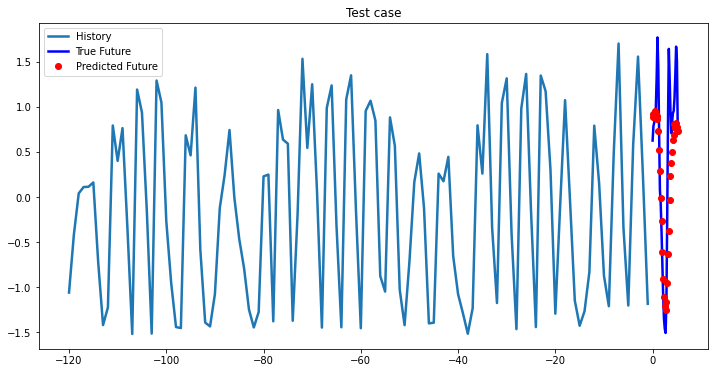

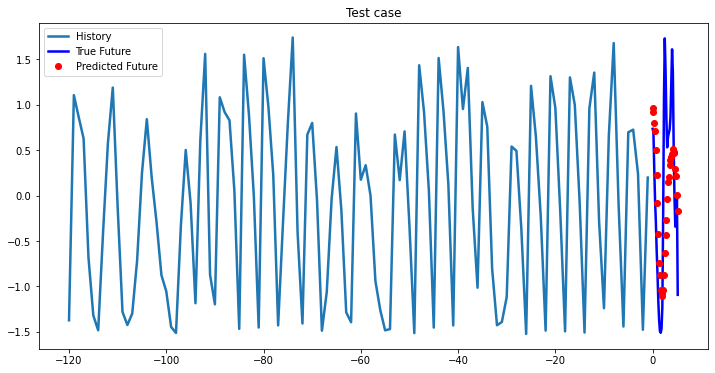

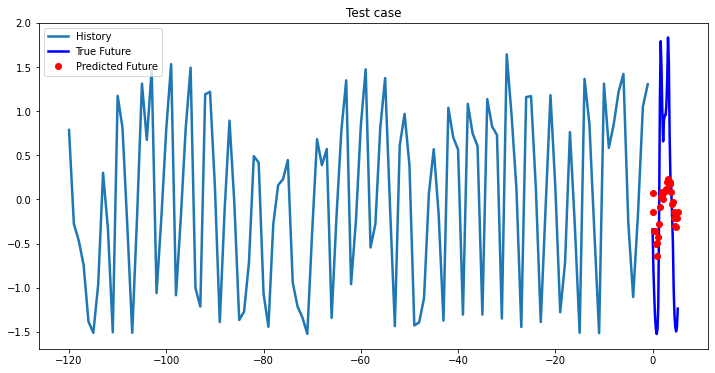

In [42]:
i = 0
while i < len(testX):
    test_x = testX[i].unsqueeze(0)
    test_y = testY[i].unsqueeze(0)
    multi_step_plot(test_x.numpy()[0, :, target_index], test_y.detach().numpy()[0, :], lstm_model(test_x).detach().numpy()[0, :], 'Test case')
    i += 100

### Experimental results on val data

| Model      | Best MSE loss          |
| ------------- |:-------------:|
| 1-layer LSTM    | 0.66802 |
| 2-layer LSTM      | 0.66578 |
|Bidirectional 1-layer LSTM  | 0.66894 |
